# CS 229 Final Project

Authors: Imogen Gardiner, Zofia Dudek, Galen Topper

## Project Overview:

Our project involves building machine learning models to improve the prediction of progression of breast cancer.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from utils import datasets, train_and_eval_model, run_hparam_search, hyperparameter_search_logisitc


#### Processing the data

In [2]:
# Read in the dataset
bc_data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t')
print(bc_data.head())

# Handle NaN values

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

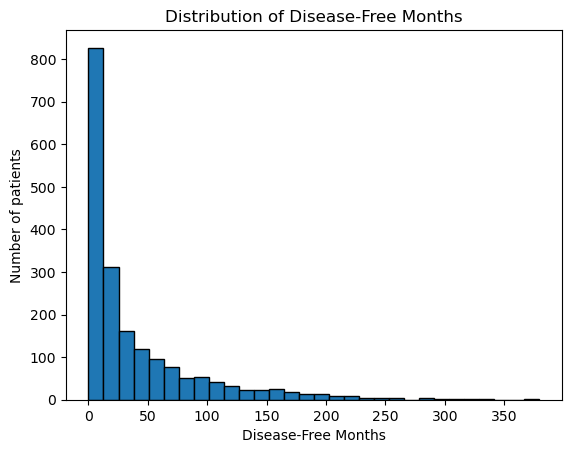

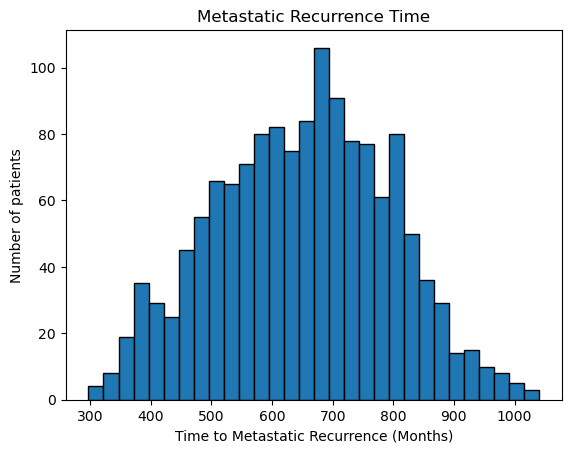

In [6]:
# Visualize the data

# Disease-free months
plt.hist(bc_data['Disease Free (Months)'], bins=30, edgecolor='black')
plt.xlabel('Disease-Free Months')
plt.ylabel('Number of patients')
plt.title('Distribution of Disease-Free Months')
plt.show()

# Metastatic recurrence time
plt.hist(bc_data['Metastatic Recurrence Time'], bins=30, edgecolor='black')
plt.xlabel('Time to Metastatic Recurrence (Months)')
plt.ylabel('Number of patients')
plt.title('Metastatic Recurrence Time')
plt.show()


In [7]:
# Split data into train, valid, test sets

train_idx, valid_idx, test_idx = None, None, None 

train_idx, test_idx = train_test_split(bc_data.index, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)

In [8]:
# Now, split up features and labels
ds_instance = datasets(
    train_X = bc_data.loc[train_idx],
    valid_X = bc_data.loc[valid_idx],
    test_X = bc_data.loc[test_idx],
    train_y = bc_data.loc[train_idx, "Metastatic Recurrence Time"],
    valid_y = bc_data.loc[valid_idx, "Metastatic Recurrence Time"],
    test_y = bc_data.loc[test_idx, "Metastatic Recurrence Time"],
    )


In [9]:
print(bc_data.dtypes)
print(bc_data["HER2 IHC Score of Sequenced Sample"].unique())
print(bc_data["PR PCT Primary"].unique())


Study ID                                          object
Patient ID                                        object
Sample ID                                         object
Cancer Type                                       object
Cancer Type Detailed                              object
Disease Free Event                                 int64
Disease Free (Months)                            float64
ER PCT Primary                                    object
ER Status of Sequenced Sample                     object
ER Status of the Primary                          object
Fraction Genome Altered                          float64
HER2 FISH Status of Sequenced Sample              object
HER2 FISH Ratio Value of Sequenced Sample         object
HER2 FISH Ratio Primary                           object
HER2 FISH Status (Report and ASCO) of Primary     object
HER2 IHC Status Primary                           object
HER2 IHC Score of Sequenced Sample                object
HER2 IHC Status of Sequenced Sa

#### Training a logistic regression model

In [10]:
# Features (remove the target variable and unnecessary columns)
X = bc_data.drop(columns=[
    "Metastatic Disease at Last Follow-up",  # Target column
    "Study ID", "Patient ID", "Sample ID",  # IDs not useful for prediction
    "Last Communication Contact",  # Metadata
    "Patient's Vital Status",  # More of an outcome variable than predictive feature and may overlap with target
    "Somatic Status", # All samples were matched - does not provide any information
    "Prior Local Recurrence", # Could overlap with target **check this**
    "Number of Samples Per Patient", # No direct predictive value, could introduce noise
    "NGS Sample Collection Time Period", # Logisitcal metadata
    "Metastatic Recurrence Time", # High overlap with target
    "Overall Survival (Months)", # More of an outcome variable than predictive feature, may overlap with target
    "Overall Survival Status", # Outcome feature and potential overlap with target
    "Time To Death (Months)", # Outcome feature and potential overlap with target
    "Disease Free (Months)", # Potential overlap with target
    "Disease Free Event", # Potential overlap with target
    "Primary Tumor Laterality", # Unlikely to have predicive value, may introduce noise
    "Sample Type", # Overlap with target
    "Site of Sample" # Overlap with target (samples that come from other sites of the body indicate metastasis)
]) 
print(X.dtypes)

Cancer Type                                       object
Cancer Type Detailed                              object
ER PCT Primary                                    object
ER Status of Sequenced Sample                     object
ER Status of the Primary                          object
Fraction Genome Altered                          float64
HER2 FISH Status of Sequenced Sample              object
HER2 FISH Ratio Value of Sequenced Sample         object
HER2 FISH Ratio Primary                           object
HER2 FISH Status (Report and ASCO) of Primary     object
HER2 IHC Status Primary                           object
HER2 IHC Score of Sequenced Sample                object
HER2 IHC Status of Sequenced Sample               object
HER2 IHC Score Primary                            object
HER2 Primary Status                               object
Overall HR Status of Sequenced Sample             object
Invasive Carcinoma Diagnosis Age                   int64
Time to Diagnosis Invasive Carc

In [11]:

# Extract features and labels
# Target variable (label)
y = bc_data["Metastatic Disease at Last Follow-up"]
y = y.map({"No": 0, "Yes": 1})  


# Features (remove the target variable and unnecessary columns)
X = bc_data.drop(columns=[
    "Metastatic Disease at Last Follow-up",  # Target column
    "Study ID", "Patient ID", "Sample ID",  # IDs not useful for prediction
    "Last Communication Contact",  # Metadata
    "Patient's Vital Status",  # More of an outcome variable than predictive feature and may overlap with target
    "Somatic Status", # All samples were matched - does not provide any information
    "Prior Local Recurrence", # Could overlap with target **check this**
    "Number of Samples Per Patient", # No direct predictive value, could introduce noise
    "NGS Sample Collection Time Period", # Logisitcal metadata
    "Metastatic Recurrence Time", # High overlap with target
    "Overall Survival (Months)", # More of an outcome variable than predictive feature, may overlap with target
    "Overall Survival Status", # Outcome feature and potential overlap with target
    "Time To Death (Months)", # Outcome feature and potential overlap with target
    "Disease Free (Months)", # Potential overlap with target
    "Disease Free Event", # Potential overlap with target
    "Primary Tumor Laterality", # Unlikely to have predicive value, may introduce noise
    "Sample Type", # Overlap with target
    "Site of Sample" # Overlap with target (samples that come from other sites of the body indicate metastasis)
]) 

# Other features to consider removing: 
# "Prior Breast Primary" - may not add significant information bc we have other tumor features, also could overlap with target 
# "Prior Local Recurrence" - Could overlap with target **check this**

# Featuers to consider keeping: Disease Free (Months), Disease Free Event

# Features to keep: tumor sample histology, ER, PR, and HER-2 related features, 
# menopausal status at diagnosis, cancer stage features, age, sex, time to diagnosis

# Feature Trannsformation

categorical_columns = [
    "Cancer Type",
    "Cancer Type Detailed",
    "ER Status of Sequenced Sample",
    "ER Status of the Primary",
    "HER2 FISH Status of Sequenced Sample",
    "HER2 FISH Status (Report and ASCO) of Primary",
    "HER2 IHC Status Primary",
    "HER2 IHC Status of Sequenced Sample",
    "HER2 Primary Status",
    "Overall HR Status of Sequenced Sample",
    "M Stage",
    "Menopausal Status At Diagnosis",
    "N Stage",
    "Oncotree Code",
    "Overall HER2 Status of Sequenced Sample",
    "Overall Patient HER2 Status",
    "Overall Patient HR Status",
    "Overall Patient Receptor Status",
    "Overall Primary Tumor Grade",
    "PR Status of Sequenced Sample",
    "PR Status of the Primary",
    "Primary Nuclear Grade",
    "Prior Breast Primary",
    "Receptor Status Primary",
    "Sex",
    "Stage At Diagnosis",
    "T Stage",
    "Tumor Sample Histology",
    "Tumor Tissue Origin",
]

X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True) # Add to X
X = X.drop(columns=categorical_columns)
X = pd.concat([X, X_encoded], axis=1)


# Define mappings for categorical columns
her2_mapping = {
    "0+": 0,
    "1+": 1,
    "2+": 2,
    "3+": 3,
    "1-2+": 1.5,  # Average for ranges
    "Not Done": None  # Convert to NaN
}

# Map HER2 IHC Score columns
X["HER2 IHC Score of Sequenced Sample"] = X["HER2 IHC Score of Sequenced Sample"].map(her2_mapping)
X["HER2 IHC Score Primary"] = X["HER2 IHC Score Primary"].map(her2_mapping)

# Clean numeric-like columns with regex
def clean_numeric(value):
    if isinstance(value, str):
        match = re.search(r"[-+]?[0-9]*\.?[0-9]+", value)
        if match:
            return float(match.group())
    return value  # Keep as is for numeric values

X["ER PCT Primary"] = X["ER PCT Primary"].apply(clean_numeric)
X["PR PCT Primary"] = X["PR PCT Primary"].apply(clean_numeric)

# Convert to numeric and handle non-numeric values (e.g., "Not Done")
X["ER PCT Primary"] = pd.to_numeric(X["ER PCT Primary"], errors="coerce")
X["PR PCT Primary"] = pd.to_numeric(X["PR PCT Primary"], errors="coerce")



# Set up stratified cross-validation
# Outer CV for train-test split
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Inner CV for train-validation split
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store final results for the test set
test_scores = []

# Hyperparameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.5, 0.9, 1]
}

for train_val_index, test_index in outer_cv.split(X, y):
    # Split into train-validation and test
    X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
    y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]

    # Preprocess data
    # Data imputation
    imputer = SimpleImputer(strategy="median")
    X_train_val = imputer.fit_transform(X_train_val)
    X_test = imputer.transform(X_test)

    # Data standardization
    numeric_columns = X.select_dtypes(include=["float64", "int64"]).columns
    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val[numeric_columns])
    X_test = scaler.transform(X_test[numeric_columns])

    # Perform hyperparameter tuning using the inner CV loop
    search_results = hyperparameter_search_logisitc(X_train_val, y_train_val, param_grid, inner_cv)
    best_params = search_results["best_params"]
    print(f"Best Params (Inner CV): {best_params}, Best Validation ROC AUC: {search_results['best_score']:.4f}")

    # Train the final model with the best hyperparameters on the entire train-validation set
    model = LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=best_params[1],
        max_iter=10000,
        C=best_params[0],
        class_weight="balanced"
    )
    model.fit(X_train_val, y_train_val)

    # Evaluate on the test set
    test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    test_scores.append(test_score)
    print(f"Test ROC AUC Score (Outer CV): {test_score:.4f}")

# Final Results
print(f"Mean Test ROC AUC Score: {np.mean(test_scores):.4f}")






TypeError: the first argument must be callable

#### Evaluating the logistic regression model

In [61]:
# Code to train logistic regression model

#### Training an XGBoost model
We have many missing values, which XGBoost can handle well.

Metrics: {'train': 0.45185138266888114, 'valid': 92.33603284407312, 'test': 86.9274697431041}


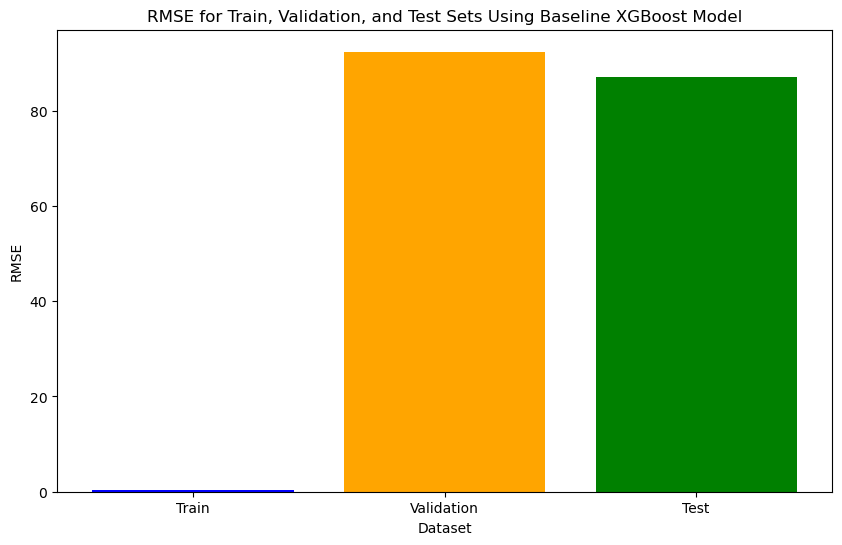

In [12]:
# Handle categorical features
categorical_features = ds_instance.train_X.select_dtypes(include=["object"]).columns

for col in categorical_features:
    ds_instance.train_X[col] = ds_instance.train_X[col].astype("category")
    ds_instance.valid_X[col] = ds_instance.valid_X[col].astype("category")
    ds_instance.test_X[col] = ds_instance.test_X[col].astype("category")

# Define XGBoost model
XGB_model = XGBRegressor(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=5, enable_categorical=True)

# Define features to include
features_to_include = ["Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
                       "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
                       "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
                       "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
                       "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
                       "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
                       "Menopausal Status At Diagnosis", "Metastatic Disease at Last Follow-up", "Mutation Count", 
                       "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", "Overall Survival Status", 
                       "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
                       "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
                       "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
                       "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
                       "Time To Death (Months)", "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin", "Patient's Vital Status"]

# Remove rows with NaN values in the features to include
ds_instance.train_X = ds_instance.train_X[features_to_include].dropna()
ds_instance.valid_X = ds_instance.valid_X[features_to_include].dropna()
ds_instance.test_X = ds_instance.test_X[features_to_include].dropna()

# Ensure the target variable has no NaN values
ds_instance.train_y = ds_instance.train_y[ds_instance.train_X.index]
ds_instance.valid_y = ds_instance.valid_y[ds_instance.valid_X.index]
ds_instance.test_y = ds_instance.test_y[ds_instance.test_X.index]

# Train and evaluate XGBoost model
predictions, metrics = train_and_eval_model(model=XGB_model, ds=ds_instance, features_to_include=features_to_include)

# Report metrics
print("Metrics:", metrics)

# Plot metrics
# Extract the metrics
train_rmse = metrics['train']
valid_rmse = metrics['valid']
test_rmse = metrics['test']

# Create a bar plot
labels = ['Train', 'Validation', 'Test']
rmse_values = [train_rmse, valid_rmse, test_rmse]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('RMSE')
plt.title('RMSE for Train, Validation, and Test Sets Using Baseline XGBoost Model')
plt.show()

#### Addressing overfitting
To address overfitting, we will run a hyperparameter search and retrain the model on the best hyperparameters found.

In [13]:
# Remove categorical features from the dataset (TODO: figure out how to handle categorical features)
ds_instance.train_X = ds_instance.train_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.valid_X = ds_instance.valid_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.test_X = ds_instance.test_X.select_dtypes(include=["int", "float", "bool"])

# Update features_to_include to only include numerical features
features_to_include = ds_instance.train_X.columns.tolist()

print(len(features_to_include))

# Run a hyperparameter search
best_metrics, best_params = run_hparam_search(ds=ds_instance, features_to_include=features_to_include)

# Report best hyperparameters and model performance
print("Best Hyperparameters Found:", best_params)
print("Best Metrics Found:", best_metrics)


12


TypeError: xgboost.sklearn.XGBRegressor() got multiple values for keyword argument 'enable_categorical'

#### Training a CNN

In [ ]:
# Code to train CNN



#### Evaluating the CNN

In [ ]:
# Code to evaluate CNN model

# Confusion matrix

In [ ]:
# Code to run a hyperparameter search for the CNN